In [1]:
import logging
import tensorflow as tf
import numpy as np
from gbica_utils import *
from tf_powersfa import *

logging.getLogger("tensorflow").setLevel(logging.WARNING)
from tensorflow.keras.layers import *
from tensorflow.nn import *


In [2]:
n_out = 3

In [3]:
N = 1000

encoding_x = tf.placeholder("float", [N, n_out])
with tf.name_scope("encoder"):
    dense0 = tf.keras.layers.Dense(n_out)(encoding_x)
encoder_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='encoder')

dense = alt_power_whitening(dense0, n_out, 50)[0]

In [4]:
n_hidden = 64

y1, y2, y3 = tf.split(dense, 3, axis=1)

In [5]:
x1 = tf.concat([y2, y3], axis=1)
y_1 = permute_y(y1, N)
x2 = tf.concat([y1, y3], axis=1)
y_2 = permute_y(y2, N)
x3 = tf.concat([y1, y2], axis=1)
y_3 = permute_y(y3, N)
h_join1 = tf.concat([y1, x1], axis=1)
h_marg1 = tf.concat([y_1, x1], axis=1)
h_join2 = tf.concat([y2, x2], axis=1)
h_marg2 = tf.concat([y_2, x2], axis=1)
h_join3 = tf.concat([y3, x3], axis=1)
h_marg3 = tf.concat([y_3, x3], axis=1)
with tf.name_scope("estimator"):
    initial_bias = tf.keras.initializers.Constant(value=0.1)
    estimator1 = Dense(n_hidden, bias_initializer=initial_bias)
    estimator2 = Dense(n_hidden, bias_initializer=initial_bias)
    estimator3 = Dense(n_hidden, bias_initializer=initial_bias)
    estimator4 = Dense(n_hidden, bias_initializer=initial_bias)
    estimator5 = Dense(n_hidden, bias_initializer=initial_bias)
    estimator6 = Dense(n_hidden, bias_initializer=initial_bias)
    
    def estimator_net_merge(h_join, h_marg, estimator): 
        dense1_joint = leaky_relu(estimator[0](h_join))
        dense2_joint = leaky_relu(estimator[1](dense1_joint))
        dense3_joint = leaky_relu(estimator[2](dense2_joint))
        dense4_joint = leaky_relu(estimator[3](dense3_joint))
        dense5_joint = leaky_relu(estimator[4](dense4_joint))
        dense6_joint = estimator[5](dense5_joint)

        dense1_marg = leaky_relu(estimator[0](h_marg))
        dense2_marg = leaky_relu(estimator[1](dense1_marg))
        dense3_marg = leaky_relu(estimator[2](dense2_marg))
        dense4_marg = leaky_relu(estimator[3](dense3_marg))
        dense5_marg = leaky_relu(estimator[4](dense4_marg))
        dense6_marg = estimator[5](dense5_marg)
        return dense6_joint, dense6_marg
    
    dense7_joint1, dense7_marg1 = estimator_net_merge(h_join1, h_marg1, [estimator1, estimator2,
                                                estimator3, estimator4, estimator5, estimator6])
    dense7_joint2, dense7_marg2 = estimator_net_merge(h_join2, h_marg2, [estimator1, estimator2,
                                                estimator3, estimator4, estimator5, estimator6])
    dense7_joint3, dense7_marg3 = estimator_net_merge(h_join3, h_marg3, [estimator1, estimator2,
                                                estimator3, estimator4, estimator5, estimator6])

estimator_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='estimator')

loss1 = tf.reduce_mean(dense7_joint1)-tf.log(tf.reduce_mean(tf.exp(dense7_marg1)))
loss2 = tf.reduce_mean(dense7_joint2)-tf.log(tf.reduce_mean(tf.exp(dense7_marg2)))
loss3 = tf.reduce_mean(dense7_joint3)-tf.log(tf.reduce_mean(tf.exp(dense7_marg3)))

In [6]:
estimator_loss = -(loss1+loss2+loss3)

total_encoder_loss = loss1+loss2+loss3
lr = 0.005

train_encoders = tf.contrib.opt.NadamOptimizer(lr).minimize(total_encoder_loss, var_list=encoder_var_list)

regularizer = tf.contrib.layers.l2_regularizer(scale=0.001)

for var in estimator_var_list:
    tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, var)
reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
reg_term = tf.contrib.layers.apply_regularization(regularizer, reg_variables)
estimator_loss += reg_term
train_estimators =  tf.contrib.opt.NadamOptimizer(lr).minimize(estimator_loss, var_list=estimator_var_list) 

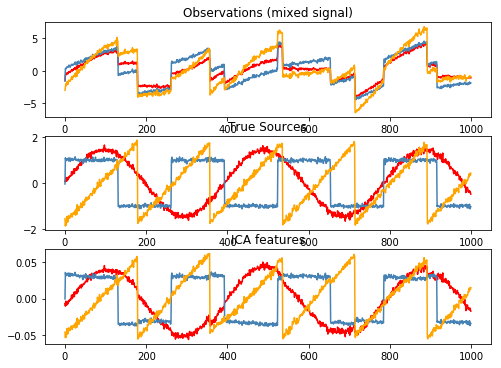

In [ ]:
%matplotlib inline

X, ica, S, S_ = bss3_experiment(N)

models = [X, S, S_]
names = ['Observations (mixed signal)', 'True Sources', 'ICA features']
colors = ['red', 'steelblue', "orange"]
plt.figure(figsize=(8, 8))
for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)
plt.show()

step: 0, loss1: -0.024, loss2: -0.024, loss3: -0.024, all_loss: -0.072


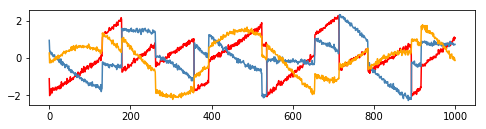

step: 250, loss1: 0.75, loss2: 0.96, loss3: 0.12, all_loss: 1.8


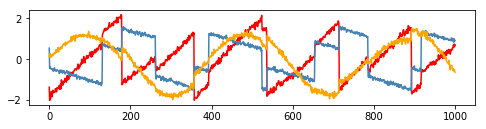

step: 500, loss1: 0.51, loss2: 0.63, loss3: 0.7, all_loss: 1.8


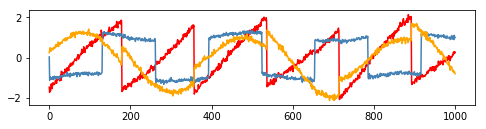

step: 750, loss1: 0.57, loss2: 0.16, loss3: 0.52, all_loss: 1.2


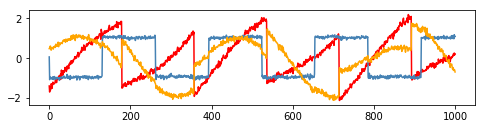

step: 1000, loss1: 0.72, loss2: 0.35, loss3: 0.59, all_loss: 1.7


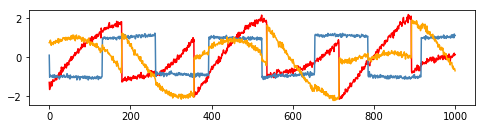

step: 1250, loss1: 0.63, loss2: 0.23, loss3: 0.81, all_loss: 1.7


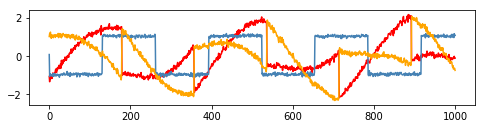

step: 1500, loss1: 0.84, loss2: 0.33, loss3: 0.73, all_loss: 1.9


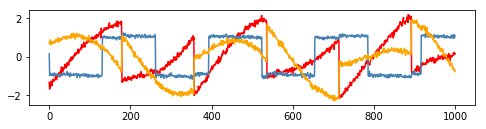

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver(encoder_var_list)
with tf.Session() as sess:
    sess.run(init)
    for i in range(2001):
        current_loss1, current_loss2, current_loss3, _ = sess.run([loss1,
                                                    loss2, loss3, train_estimators], feed_dict={encoding_x:X})

        if i % 7   is 0: 
            _ = sess.run(train_encoders, feed_dict={encoding_x:X})

        if i % 250 is 0:
            print("step: {}, loss1: {:.2}, loss2: {:.2}, loss3: {:.2}, all_loss: {:.2}".format(i,
                                current_loss1, current_loss2, current_loss3, current_loss1+current_loss2+current_loss3))
            plt.figure(figsize=(8, 8))
            plt.subplot(4, 1, 1)
            encoding = sess.run(dense, feed_dict={encoding_x:X})
            for j in range(encoding.shape[1]):
                plt.plot(encoding[:, j], color = colors[j])
            plt.show()